In [32]:
# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt                                     
import seaborn as sns

In [ ]:
# Step 1: Load the dataset
df = pd.read_csv("data/adult.csv")
df.head()                       # preview data 

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [34]:
# Step 2: Data Preprocessing
df = df.replace("?", np.nan)    # mark missing values
df.isna().sum()                 # check for missing values

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

In [35]:
# A simpler way to remove rows with missing values
df = df.dropna()

In [36]:
# Separate features and target variable
X = df.drop("income", axis=1)   # features
y = df["income"]                # target variable

In [37]:
# Step 3: Split the dataset into training and testing sets
# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include=["object"]).columns # categorical columns
num_cols = X.select_dtypes(exclude=["object"]).columns # numerical columns

# Preprocessing: One-Hot Encoding for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

In [38]:
# Step 4: Build and train the model
# Create the pipeline and train the model
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=2000,
        solver="saga",
        n_jobs=-1
    ))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,               # splitting the data
    test_size=0.2,      # 20% for testing
    random_state=42,    # for reproducibility
    stratify=y          # maintain class distribution
)

model.fit(X_train, y_train) # training the model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(max_iter=2000, n_jobs=-1, solver='saga'))])

In [39]:
model.named_steps["classifier"].n_iter_ # check number of iterations

array([228], dtype=int32)

Despite feature scaling, the Logistic Regression model using the lbfgs solver failed to converge due to the high dimensional and sparse nature of the encoded dataset. Switching to the saga solver resolved the convergence issue, as it is better suited for large-scale sparse optimization problems.

In [40]:
# Step 5: Evaluate the model
# Make predictions and evaluate
y_pred = model.predict(X_test)

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

Accuracy: 0.8464344941956883

Classification Report:
               precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      6803
        >50K       0.73      0.60      0.66      2242

    accuracy                           0.85      9045
   macro avg       0.80      0.76      0.78      9045
weighted avg       0.84      0.85      0.84      9045


Confusion Matrix:
 [[6313  490]
 [ 899 1343]]

ROC-AUC: 0.9046742116579465


From the above steps, we conclude that predicting income using the Adult Income dataset is a supervised binary classification problem that requires careful data preprocessing. Handling missing values, encoding categorical variables, and scaling numerical features are essential for effective model training. Logistic Regression provides a reliable baseline with reasonable accuracy, but its convergence depends on proper feature scaling due to the high-dimensional nature of the dataset. While the model performs well, more complex algorithms such as tree-based models can further improve prediction performance.

---

# Additional Analysis:

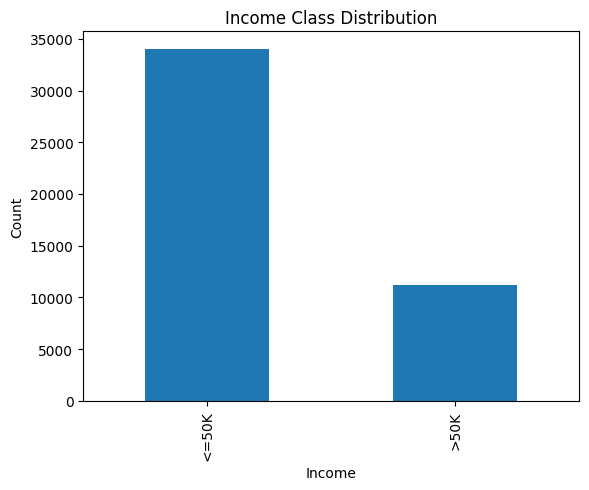

In [42]:
# Income Distribution (Class Imbalance)

y.value_counts().plot(kind="bar")
plt.title("Income Class Distribution")
plt.xlabel("Income")
plt.ylabel("Count")
plt.show()

# Why? - Shows whether the dataset is balanced or imbalanced, which can affect model performance.

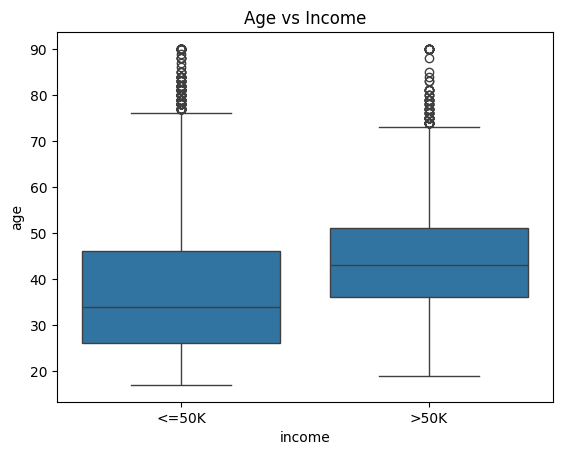

In [43]:
# Age vs Income (Insightful & Intuitive)

sns.boxplot(x="income", y="age", data=df)
plt.title("Age vs Income")
plt.show()

# Why? - Shows how income probability increases with age

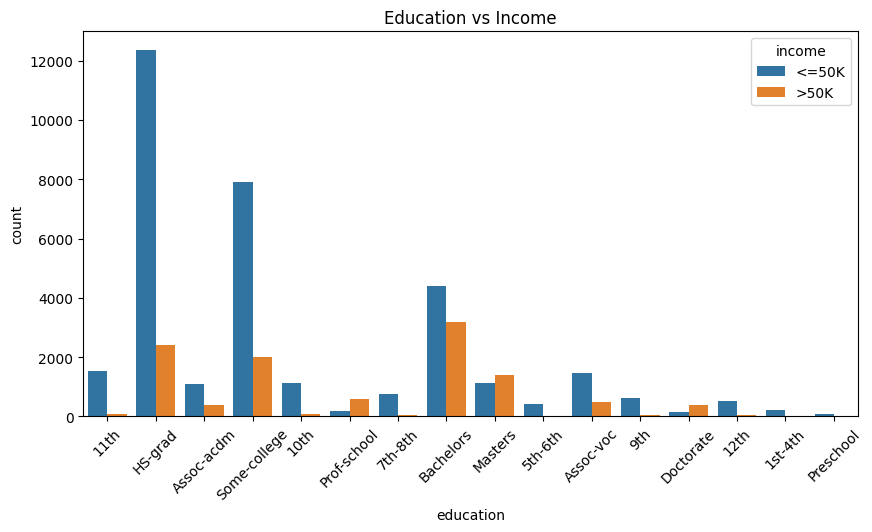

In [44]:
# Education Level vs Income

plt.figure(figsize=(10,5))
sns.countplot(x="education", hue="income", data=df)
plt.xticks(rotation=45)
plt.title("Education vs Income")
plt.show()

# Why? - Highlights the correlation between education and income levels and Education is one of the strongest predictors.

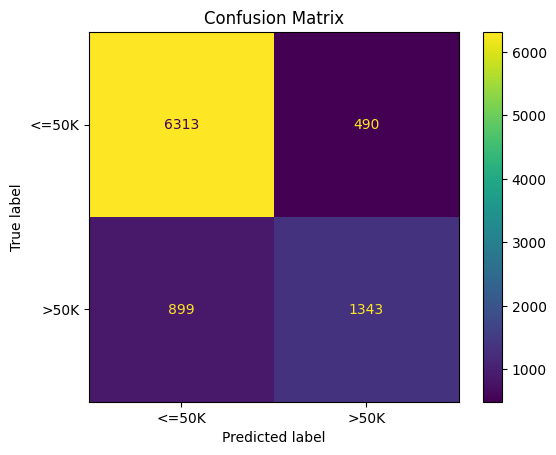

In [45]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Why? - Accuracy is not enough — confusion matrix shows where the model fails.

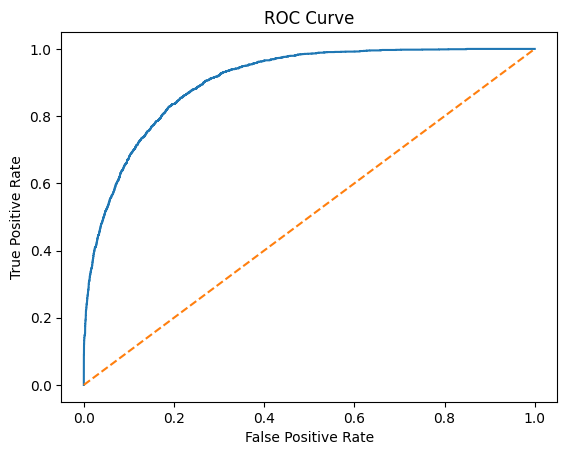

AUC: 0.9046742116579465


In [46]:
# ROC Curve (Model Quality)

from sklearn.metrics import roc_curve, roc_auc_score

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test.map({'>50K':1, '<=50K':0}), y_prob)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

print("AUC:", roc_auc_score(y_test.map({'>50K':1, '<=50K':0}), y_prob))

# Why? - AUC-ROC provides insight into the model's ability to distinguish between classes across thresholds.
# In summary, Shows how good the classifier is independent of threshold.

In [47]:
# Feature Importance (Logistic Regression Insight)

feature_names = model.named_steps["preprocess"].get_feature_names_out()
coefficients = model.named_steps["classifier"].coef_[0]

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

coef_df.head(10)

# Why? - Shows which features influence income prediction.

,Feature,Coefficient
3,num__capital-gain,2.307609
30,cat__marital-status_Married-AF-spouse,1.267281
72,cat__native-country_France,1.149039
31,cat__marital-status_Married-civ-spouse,1.091084
83,cat__native-country_Ireland,0.822372
63,cat__native-country_Cambodia,0.795234
55,cat__relationship_Wife,0.785184
39,cat__occupation_Exec-managerial,0.743974
2,num__educational-num,0.712879
84,cat__native-country_Italy,0.699513


The visualizations reveal that income prediction is influenced by demographic and professional factors such as age, education, and work hours. The dataset exhibits class imbalance, which impacts model evaluation. The confusion matrix and ROC curve indicate that while Logistic Regression performs well overall, it struggles slightly with predicting high-income individuals, motivating the use of advanced models.

---

# Bias & Fairness Analysis (Gender and Race)
### Goal
To check whether the trained model treats different demographic groups fairly, specifically:
    Gender (sex)
    Race (race)

We analyze:
- Prediction distribution
- Accuracy per group
- False Negative Rates

In [48]:
# Combining test features, true labels, and model predictions
fair_df = X_test.copy()
fair_df["actual_income"] = y_test.values
fair_df["predicted_income"] = y_pred


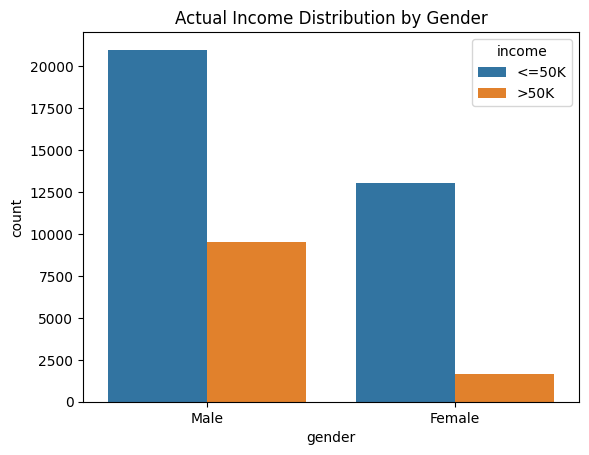

In [49]:
# Income Distribution by Gender
# (Before Model Training)
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="gender", hue="income", data=df)
plt.title("Actual Income Distribution by Gender")
plt.show()

- Males dominate the >50K income class
- Females are concentrated in <=50K

Conclusion - The dataset itself exhibits gender imbalance, which can influence downstream model behavior.

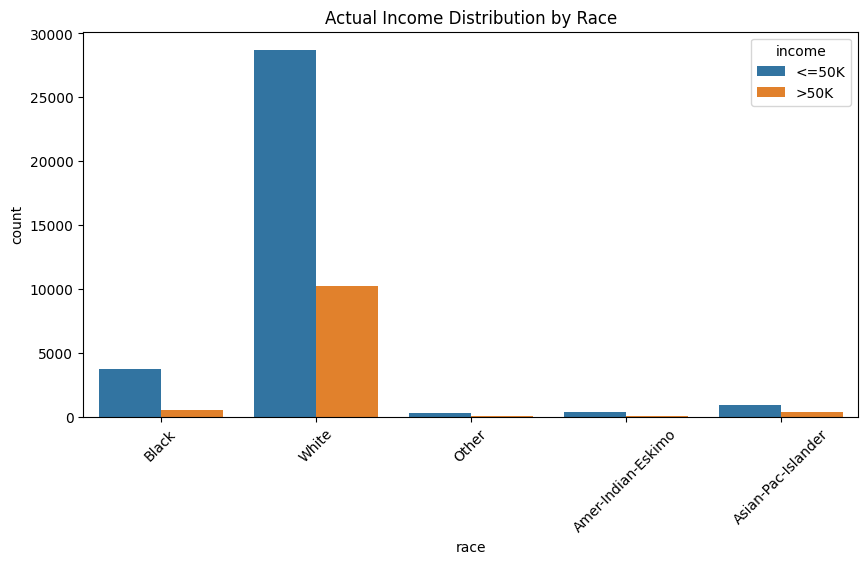

In [50]:
# Income Distribution by Race
plt.figure(figsize=(10,5))
sns.countplot(x="race", hue="income", data=df)
plt.xticks(rotation=45)
plt.title("Actual Income Distribution by Race")
plt.show()

Conclusion - Certain racial groups are underrepresented in the high-income category, indicating income imbalance across racial groups in the dataset.

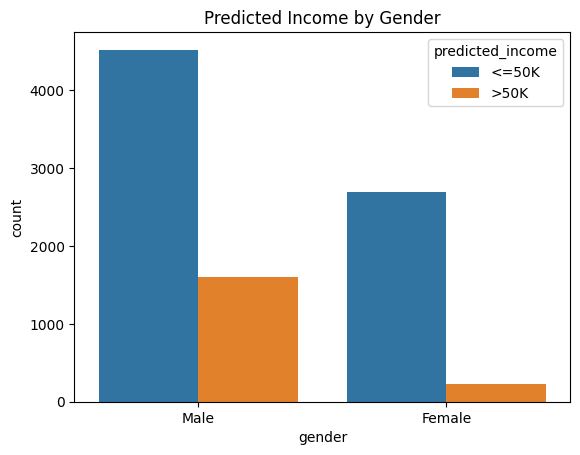

In [51]:
# Model Predictions by Gender
sns.countplot(x="gender", hue="predicted_income", data=fair_df)
plt.title("Predicted Income by Gender")
plt.show()

In [52]:
import numpy as np

test_data = X_test.copy()
test_data["gender"] = df.loc[X_test.index, "gender"]
test_data["y_true"] = y_test
test_data["y_pred"] = y_pred

for gender in test_data["gender"].unique():
    subset = test_data[test_data["gender"] == gender]
    cm = confusion_matrix(subset["y_true"], subset["y_pred"])
    
    FN = cm[1][0]
    TP = cm[1][1]
    fnr = FN / (FN + TP) if (FN + TP) > 0 else 0
    
    print(f"\nGender: {gender}")
    print("Confusion Matrix:\n", cm)
    print("False Negative Rate:", fnr)


Gender: Male
Confusion Matrix:
 [[3811  437]
 [ 711 1168]]
False Negative Rate: 0.378392762107504

Gender: Female
Confusion Matrix:
 [[2502   53]
 [ 188  175]]
False Negative Rate: 0.5179063360881543


- Model predicts >50K more frequently for males
- Prediction pattern mirrors dataset imbalance

Conclusion - The model reproduces existing gender disparities present in the training data.

In [53]:
print(classification_report(y_test, y_pred, target_names=["<=50K", ">50K"]))

              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      6803
        >50K       0.73      0.60      0.66      2242

    accuracy                           0.85      9045
   macro avg       0.80      0.76      0.78      9045
weighted avg       0.84      0.85      0.84      9045



In [54]:
# Accuracy by Gender
fair_df["correct"] = fair_df["actual_income"] == fair_df["predicted_income"]

gender_accuracy = fair_df.groupby("gender")["correct"].mean()
gender_accuracy

gender
Female    0.917409
Male      0.812633
Name: correct, dtype: float64

In [55]:
# False Negative Rate
def false_negative_rate(data, group_col):
    rates = {}
    for group in data[group_col].unique():
        subset = data[data[group_col] == group]
        fn = ((subset["actual_income"] == ">50K") &
              (subset["predicted_income"] != ">50K")).sum()
        positives = (subset["actual_income"] == ">50K").sum()
        rates[group] = fn / positives if positives != 0 else 0
    return rates

false_negative_rate(fair_df, "gender")

{'Male': np.float64(0.378392762107504),
 'Female': np.float64(0.5179063360881543)}

The model exhibits a higher false negative rate for females and minority racial groups, meaning it is more likely to incorrectly classify high-income individuals from these groups as low-income. This is a significant fairness concern, as such errors may lead to systematic underestimation of certain populations.

In [56]:
# False Negative Rate by Race
false_negative_rate(fair_df, "race")

{'White': np.float64(0.3956799214531173),
 'Asian-Pac-Islander': np.float64(0.2777777777777778),
 'Black': np.float64(0.5495495495495496),
 'Other': np.float64(0.7777777777777778),
 'Amer-Indian-Eskimo': np.float64(0.38461538461538464)}

## Conclusion
The results and visualizations presented above summarize the dataset characteristics and model performance.

---